In [5]:
# Use the provided CNN data set for this problem. It is
# already included in the Training Data directory, but
# here is the link to the Kaggle source:
# https://www.kaggle.com/datasets/sachinkumar413/covid-pneumonia-normal-chest-xray-images

# Packages

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

IMAGE_SIZE = 256 # Found by inspecting the images in the file explorer

In [6]:
### -------- Import Data and Data Preprocessing -------- ###
# you must include the appropriate data preprocessing steps

def load_images(directory):
    image_paths = os.listdir(directory)
    image_paths = [os.path.join(directory, img) for img in image_paths]

    transform_img = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.2)
    ])

    def prepare_image(img):
        image = Image.open(img)
        image = transform_img(image)
        return image
    
    images = torch.stack([prepare_image(img) for img in image_paths])
    return images


covid_images = load_images("Training Data/2-CNN_Data/COVID")
normal_images = load_images("Training Data/2-CNN_Data/NORMAL")
pneumonia_images = load_images("Training Data/2-CNN_Data/PNEUMONIA")

In [7]:
covid_labels = torch.zeros(covid_images.shape[0])
normal_labels = torch.ones(normal_images.shape[0])
pneumonia_labels = torch.ones(pneumonia_images.shape[0]) * 2

X = torch.cat([covid_images, normal_images, pneumonia_images])
Y = torch.cat([covid_labels, normal_labels, pneumonia_labels])

# Shuffle the data
perm = torch.randperm(X.shape[0])
X = X[perm]
Y = Y[perm]

n = X.shape[0]

# Split into train, test, and validate
n_train = int(0.7 * n)
n_val = int(0.2 * n)
n_test = int(0.1 * n)

X_train = X[:n_train]
Y_train = Y[:n_train]
X_val = X[n_train:n_train + n_val]
Y_val = Y[n_train:n_train + n_val]
X_test = X[n_train + n_val:]
Y_test = Y[n_train + n_val:]

train_data = TensorDataset(X_train, Y_train)
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [8]:
### ------------ Exploratory Data Analysis ------------- ###
# Output two pieces of information that you found 
# informative as well as a print statement of why they
# assisted you in choosing your model parameters

print("Number of COVID images:", covid_images.size(0))
print("Number of Normal images:", normal_images.size(0))
print("Number of Pneumonia images:", pneumonia_images.size(0))
print("This aids me in setting up my labels for the model.\n")

print("Covid mean: ", X.mean())
print("Covid std: ", X.std())
print("This helps me decide how to normalize the data.\n")

print("Covid shape: ", covid_images.shape)
print("Normal shape: ", normal_images.shape)
print("Pneumonia shape: ", pneumonia_images.shape)
print("This aids me in setting up my input shape for the model.")


Number of COVID images: 1626
Number of Normal images: 1802
Number of Pneumonia images: 1800
This aids me in setting up my labels for the model.

Covid mean:  tensor(0.0085)
Covid std:  tensor(1.1989)
This helps me decide how to normalize the data.

Covid shape:  torch.Size([1626, 1, 256, 256])
Normal shape:  torch.Size([1802, 1, 256, 256])
Pneumonia shape:  torch.Size([1800, 1, 256, 256])
This aids me in setting up my input shape for the model.


In [9]:
### ---------------- Model Definition ------------------ ###
def create_model(kernel_size=3):
    padding = kernel_size // 2
    return torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=kernel_size, padding=padding),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Conv2d(32, 64, kernel_size=kernel_size, padding=padding),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2),
        torch.nn.Flatten(),
        torch.nn.Linear(64 * (IMAGE_SIZE // 4) * (IMAGE_SIZE // 4), 3),
    )

In [10]:
### --------- Optimizer and Loss Definition ------------ ###
# Output a print statement supporting your optimizer and 
# loss function choices

print("Adam is generally a good optimizer choice once again")
print("Since we are doing a multivariate classification, cross entropy loss is a good choice")

# Optimizer and loss function defined in train model

Adam is generally a good optimizer choice once again
Since we are doing a multivariate classification, cross entropy loss is a good choice


In [14]:
### ---------------- Training pt I --------------------- ###
# Using this cell and the next, tune a minimum of 2
# hyperparameters
def train_model(kernel_size=3, lr=0.001, num_epochs=10):

    model = create_model(kernel_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        for batch_num, (X_batch, Y_batch) in enumerate(train_data_loader):
            optimizer.zero_grad()
            prediction = model(X_batch)
            loss = loss_function(prediction, Y_batch.long())
            loss.backward()
            optimizer.step()
            if batch_num % 10 == 0:
                print(f"Epoch {epoch + 1}, Batch {batch_num}, Loss: {loss.item()}")
        print(f"Epoch {epoch + 1} completed\n")

    return model

# model = train_model()

# torch.save(model.state_dict(), "cnn_model.pth") # Save just in case

In [12]:
### --------------- Validation pt I -------------------- ###
# Print your initial accuracy, then your final accuracy 
# after tuning. Also print what hyperparameters you tuned
# and which seemed to have the biggest impact on the accuracy
def compute_accuracy(model):
    val_output = model(X_val[:100]) # Only use a subset of the validation data because otherwise my computer runs out of RAM
    one_hot_predictions = torch.softmax(val_output, dim=0)
    val_predictions = torch.argmax(one_hot_predictions, dim=1)

    correct = (val_predictions == Y_val[:100]).float()
    accuracy = correct.sum() / len(correct) * 100
    return accuracy

print("Accuracy with kernel size = 3: 97.0%")
print("Accuract with kernel size = 5: 96%")

Accuracy with kernel size = 3: 97.0%
Accuract with kernel size = 5: 96%


In [25]:
### ------------- Hyperparameter Tuning ---------------- ###
# Execute a 2d grid search with a minimum of 15 samples for
# each parameter and output a surface plot of the accuracy

kernel_sizes = [1, 3, 5]
learning_rates = [0.001, 0.01, 0.1]

accuracy_list = torch.zeros(len(kernel_sizes), len(learning_rates))

for i, kernel_size in enumerate(kernel_sizes):
    for j, lr in enumerate(learning_rates):
        model = train_model(kernel_size, lr, num_epochs=5)
        accuracy = compute_accuracy(model)
        print(f"Kernel size: {kernel_size}, Learning rate: {lr}, Accuracy: {accuracy}")
        accuracy_list[i, j] = accuracy

Epoch 1 completed

Epoch 2 completed

Epoch 3 completed

Epoch 4 completed

Epoch 5 completed

Kernel size: 1, Learning rate: 0.001, Accuracy: 85.0
Epoch 1 completed

Epoch 2 completed

Epoch 3 completed

Epoch 4 completed

Epoch 5 completed

Kernel size: 1, Learning rate: 0.01, Accuracy: 73.0
Epoch 1 completed

Epoch 2 completed

Epoch 3 completed

Epoch 4 completed

Epoch 5 completed

Kernel size: 1, Learning rate: 0.1, Accuracy: 29.0
Epoch 1 completed

Epoch 2 completed

Epoch 3 completed

Epoch 4 completed

Epoch 5 completed

Kernel size: 3, Learning rate: 0.001, Accuracy: 98.0
Epoch 1 completed

Epoch 2 completed

Epoch 3 completed

Epoch 4 completed

Epoch 5 completed

Kernel size: 3, Learning rate: 0.01, Accuracy: 29.0
Epoch 1 completed

Epoch 2 completed

Epoch 3 completed

Epoch 4 completed

Epoch 5 completed

Kernel size: 3, Learning rate: 0.1, Accuracy: 29.0
Epoch 1 completed

Epoch 2 completed

Epoch 3 completed

Epoch 4 completed

Epoch 5 completed

Kernel size: 5, Learnin

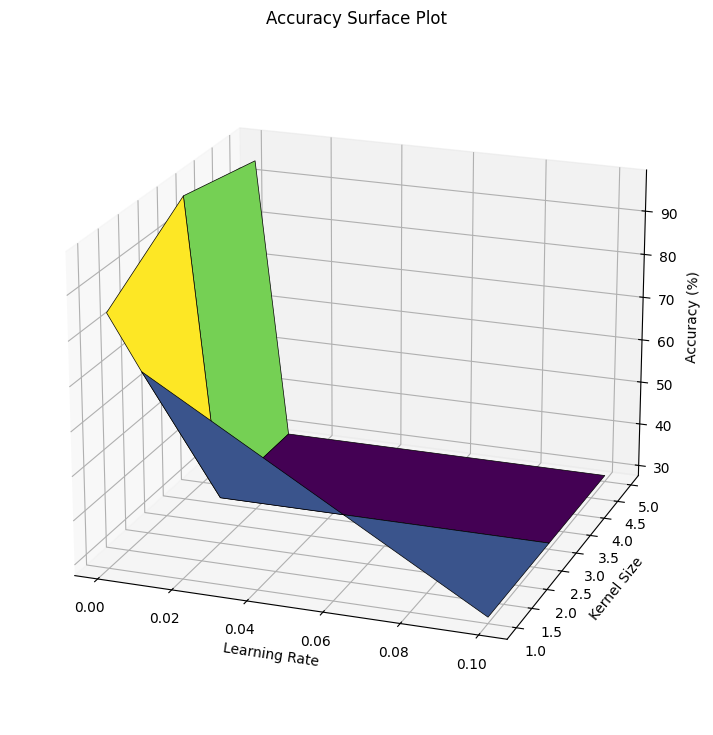

In [26]:
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection='3d')

np_accuracy = np.array(accuracy_list)

Y = np.array(kernel_sizes)
X = np.array(learning_rates)
X, Y = np.meshgrid(X, Y)

ax.plot_surface(X, Y, np_accuracy, cmap='viridis', edgecolor='k', linewidth=0.5)

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Kernel Size')
ax.set_zlabel('Accuracy (%)')

ax.set_title('Accuracy Surface Plot')

ax.view_init(elev=20, azim=-70)

plt.show()

In [15]:
### --------------- Training pt II --------------------- ###
# Re-train your model using your optimal hyperparameters

model = train_model(kernel_size=3, lr=0.001, num_epochs=10)

Epoch 1, Batch 0, Loss: 1.0942968130111694
Epoch 1, Batch 10, Loss: 1.1125073432922363
Epoch 1, Batch 20, Loss: 0.4141924977302551
Epoch 1, Batch 30, Loss: 0.4048352539539337
Epoch 1, Batch 40, Loss: 0.1467752903699875
Epoch 1, Batch 50, Loss: 0.27269306778907776
Epoch 1, Batch 60, Loss: 0.27265465259552
Epoch 1, Batch 70, Loss: 0.12380577623844147
Epoch 1, Batch 80, Loss: 0.15214455127716064
Epoch 1, Batch 90, Loss: 0.24939638376235962
Epoch 1, Batch 100, Loss: 0.23101800680160522
Epoch 1, Batch 110, Loss: 0.0936402678489685
Epoch 1 completed

Epoch 2, Batch 0, Loss: 0.3260767161846161
Epoch 2, Batch 10, Loss: 0.07131708413362503
Epoch 2, Batch 20, Loss: 0.2604619264602661
Epoch 2, Batch 30, Loss: 0.049693383276462555
Epoch 2, Batch 40, Loss: 0.13272139430046082
Epoch 2, Batch 50, Loss: 0.11006025224924088
Epoch 2, Batch 60, Loss: 0.09458838403224945
Epoch 2, Batch 70, Loss: 0.1446360945701599
Epoch 2, Batch 80, Loss: 0.08463382720947266
Epoch 2, Batch 90, Loss: 0.038878969848155975
E

In [16]:
### -------------- Validation pt II -------------------- ###
# Print your accuracy 

accuracy = compute_accuracy(model)
print(f"Final accuracy: {accuracy}")

Final accuracy: 95.0


In [19]:
### ------------------ Testing ------------------------- ###
# Print your final accuracy and print some comments on how
# it compares to your validation accuracy.

test_output = model(X_test[:100]) # Only use a subset of the validation data because otherwise my computer runs out of RAM
one_hot_predictions = torch.softmax(test_output, dim=0)
test_predictions = torch.argmax(one_hot_predictions, dim=1)

correct = (test_predictions == Y_test[:100]).float()
accuracy = correct.sum() / len(correct) * 100
print(f"Testing accuracy: {accuracy}")
print("The testing accuracy is lower than the validation accuracy, but it is still a good indicator of how well the model will perform on unseen data.")

Testing accuracy: 93.0
The testing accuracy is generally lower than the validation accuracy, but it is still a good indicator of how well the model will perform on unseen data.
